<a href="https://colab.research.google.com/github/cfitzpatrick89/ADS509-Final/blob/main/ADS509_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import xmltodict
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import json
from sklearn.decomposition import NMF
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models
from sklearn.cluster import KMeans

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [6]:
# !pip install xmltodict
# !pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Directory

In [7]:
# Function to create a directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pubmed IDs

In [8]:
# Function to fetch PubMed IDs based on a query and date range
def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Function to fetch details for PubMed IDs in batches
def fetch_pubmed_details(ids, batch_size=100):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Extract and Parse Data

In [22]:
# Function to extract text from abstract field in different formats
def extract_text_from_abstract(abstract):
    # print(f"Extracting text from abstract: {abstract}")  # Debug statement
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        extracted_text = ' '.join(text_list)
    elif isinstance(abstract, dict):
        extracted_text = abstract.get('#text', '')
    else:
        extracted_text = abstract
    # print(f"Extracted text: {extracted_text[:60]}...")  # Debug statement
    return extracted_text

# Function to parse PubMed XML Data
def parse_pubmed_details(xml_data):
    data_dict = xmltodict.parse(xml_data)
    articles = []
    for article in data_dict['PubmedArticleSet']['PubmedArticle']:
        try:
            pmid = article['MedlineCitation']['PMID']
            title = article['MedlineCitation']['Article']['ArticleTitle']
            abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
            abstract_text = extract_text_from_abstract(abstract)
            articles.append({
                'PMID': pmid,
                'Title': title,
                'Abstract': abstract_text
            })
            # print(f"Article parsed: PMID {pmid}, Title {title[:60]}...")  # Debug statement
        except KeyError:
            continue
    return articles

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# # Function to extract text from abstract field in different formats
# def extract_text_from_abstract(abstract):
#     print(f"Extracting text from abstract: {abstract}")  # Debug statement
#     if isinstance(abstract, list):
#         text_list = []
#         for item in abstract:
#             if isinstance(item, dict):
#                 text_list.append(item.get('#text', ''))
#             else:
#                 text_list.append(item)
#         extracted_text = ' '.join(text_list)
#     elif isinstance(abstract, dict):
#         extracted_text = abstract.get('#text', '')
#     else:
#         extracted_text = abstract
#     print(f"Extracted text: {extracted_text[:60]}...")  # Debug statement
#     return extracted_text

# # Function to parse PubMed XML Data in batches
# def parse_pubmed_details(xml_data_list):
#     articles = []
#     for batch_index, xml_data in enumerate(xml_data_list):
#         try:
#             print(f"Parsing batch {batch_index + 1}/{len(xml_data_list)}")  # Debug statement
#             data_dict = xmltodict.parse(xml_data)
#             for article in data_dict['PubmedArticleSet']['PubmedArticle']:
#                 try:
#                     pmid = article['MedlineCitation']['PMID']
#                     title = article['MedlineCitation']['Article']['ArticleTitle']
#                     abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
#                     abstract_text = extract_text_from_abstract(abstract)
#                     articles.append({
#                         'PMID': pmid,
#                         'Title': title,
#                         'Abstract': abstract_text
#                     })
#                     print(f"Article parsed: PMID {pmid}, Title {title[:60]}...")  # Debug statement
#                 except KeyError as e:
#                     print(f"KeyError: {e} - Skipping article")  # Debug statement
#                     continue
#         except Exception as e:
#             print(f"Error parsing XML: {e} - Skipping batch")  # Debug statement
#             continue
#     return articles



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocess Text

In [23]:
# Function to preprocess text without debug output
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# # Function to preprocess text
# def preprocess_text(text):
#     print(f"Preprocessing text: {text[:60]}...")  # Print the first 60 characters of the text for debugging
#     tokens = word_tokenize(text)  # Tokenize the text
#     print(f"Tokens: {tokens[:10]}...")  # Print the first 10 tokens for debugging
#     tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
#     print(f"Lowercased Tokens: {tokens[:10]}...")  # Print the first 10 lowercased tokens for debugging
#     tokens = [word for word in tokens if word.isalpha()]  # Remove tokens that contain non-alphabetic characters
#     print(f"Alphabetic Tokens: {tokens[:10]}...")  # Print the first 10 alphabetic tokens for debugging
#     tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
#     print(f"Tokens without Stopwords: {tokens[:10]}...")  # Print the first 10 tokens without stopwords for debugging
#     return tokens



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Descriptive Statistics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of tokens: 12966
Number of unique tokens: 3782
Average token length: 7.28
Most common tokens: [('health', 181), ('climate', 179), ('the', 137), ('change', 137), ('we', 84), ('research', 70), ('heat', 62), ('study', 54), ('exposure', 54), ('temperature', 52)]


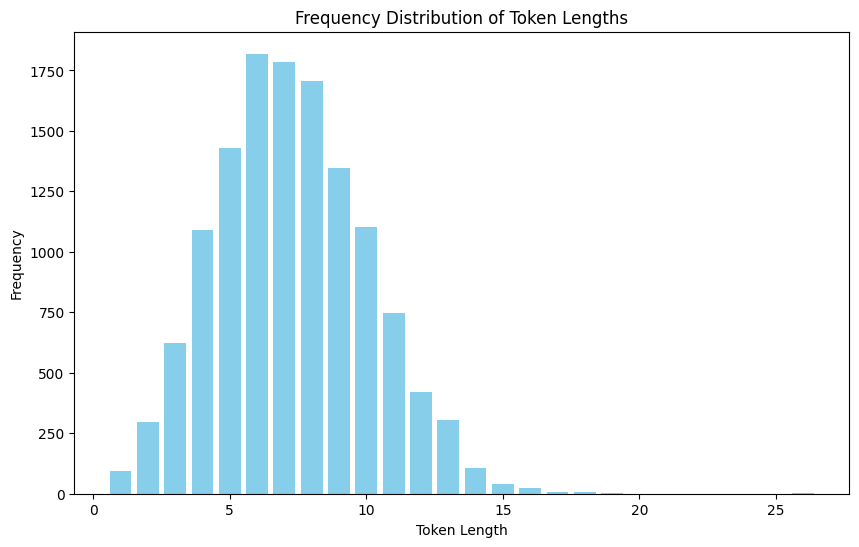

In [24]:
# Function to calculate descriptive statistics
def calculate_descriptive_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    num_tokens = len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    avg_token_length = sum(len(token) for token in tokens) / num_tokens
    token_freq = Counter(tokens)
    most_common_tokens = token_freq.most_common(10)
    token_length_freq = Counter(len(token) for token in tokens)
    print(f"Number of tokens: {num_tokens}")
    print(f"Number of unique tokens: {num_unique_tokens}")
    print(f"Average token length: {avg_token_length:.2f}")
    print(f"Most common tokens: {most_common_tokens}")
    token_length_df = pd.DataFrame(token_length_freq.items(), columns=['Token Length', 'Frequency']).sort_values(by='Token Length')
    return token_length_df

# Main function to fetch, parse, and preprocess PubMed data
def main_function():
    # Fetch PubMed IDs
    pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')

    if pubmed_ids:
        # Fetch details for each PubMed ID
        pubmed_xml = fetch_pubmed_details(pubmed_ids)

        # Parse the details
        articles = parse_pubmed_details(pubmed_xml)

        # Convert to DataFrame
        df_articles = pd.DataFrame(articles)

        # Apply preprocessing to articles' abstracts
        if not df_articles.empty:
            df_articles['processed_abstract'] = df_articles['Abstract'].apply(preprocess_text)
            # Join tokens back to strings for TF-IDF processing
            df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))

            return df_articles
        else:
            return None
    else:
        return None

# Execute the main function
df_articles = main_function()

# Check if the DataFrame is not empty before proceeding
if df_articles is not None:
    # Calculate and display descriptive statistics
    token_length_df = calculate_descriptive_statistics(df_articles, 'processed_abstract_str')

    # Plot the frequency distribution of token lengths
    plt.figure(figsize=(10, 6))
    plt.bar(token_length_df['Token Length'], token_length_df['Frequency'], color='skyblue')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Frequency Distribution of Token Lengths')
    plt.show()
else:
    print("DataFrame is empty. No articles to process.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic Modeling NMF

In [26]:
%matplotlib inline

def nmf_topic_modeling(df_articles, num_topics=5):
    # Use TF-IDF to find important terms
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df_articles['processed_abstract_str'])

    # Apply NMF for topic modeling
    nmf = NMF(n_components=num_topics, random_state=42)
    W = nmf.fit_transform(X)
    H = nmf.components_

    # Display and visualize topics
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(H):
        print(f"Topic #{topic_idx}:")
        top_terms = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        print(" ".join(top_terms))

# Plot the top terms
        top_term_weights = topic[topic.argsort()[:-10 - 1:-1]]
        plt.figure(figsize=(10, 6))
        plt.barh(top_terms, top_term_weights, color='skyblue')
        plt.xlabel('Weight')
        plt.title(f'Top Terms for Topic #{topic_idx}')
        plt.gca().invert_yaxis()
        plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMF Topic Modeling:
Topic #0:
adaptation health climate change policy public actions strategies impacts governments


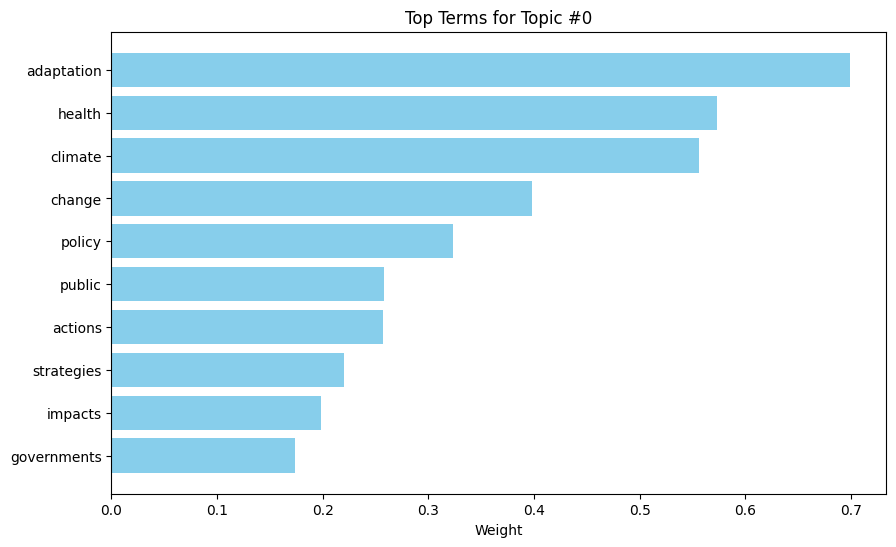

Topic #1:
heat temperature exposure mortality cold risk days levels associated spells


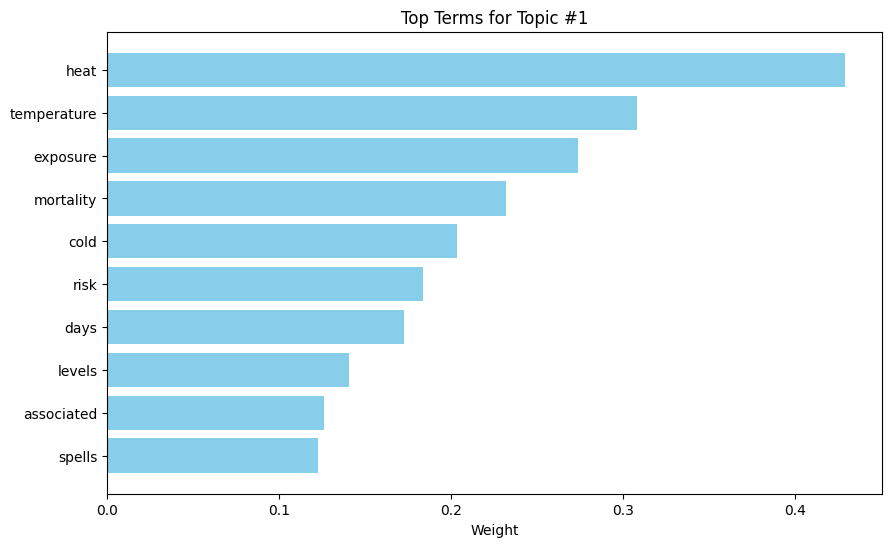

Topic #2:
species plant soil growth stress compounds food productivity germination global


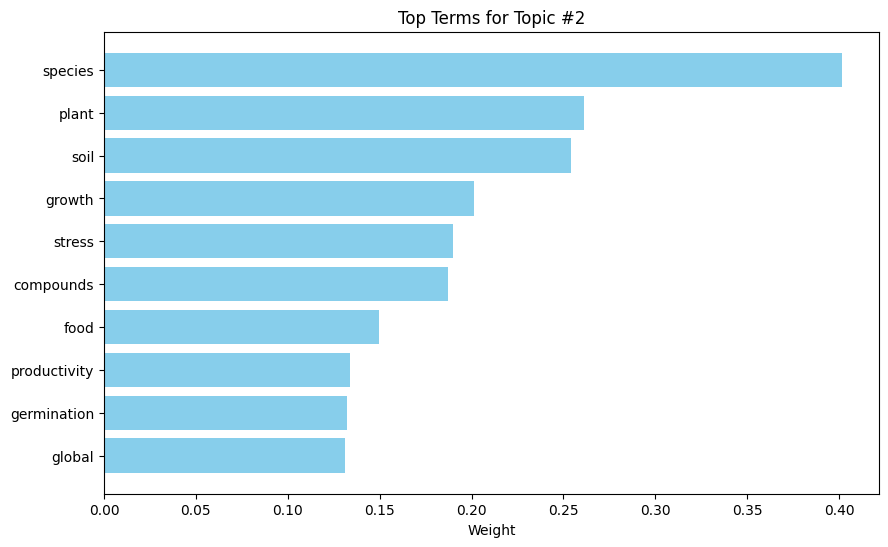

Topic #3:
research services challenges future sustainable health researchers need healthcare field


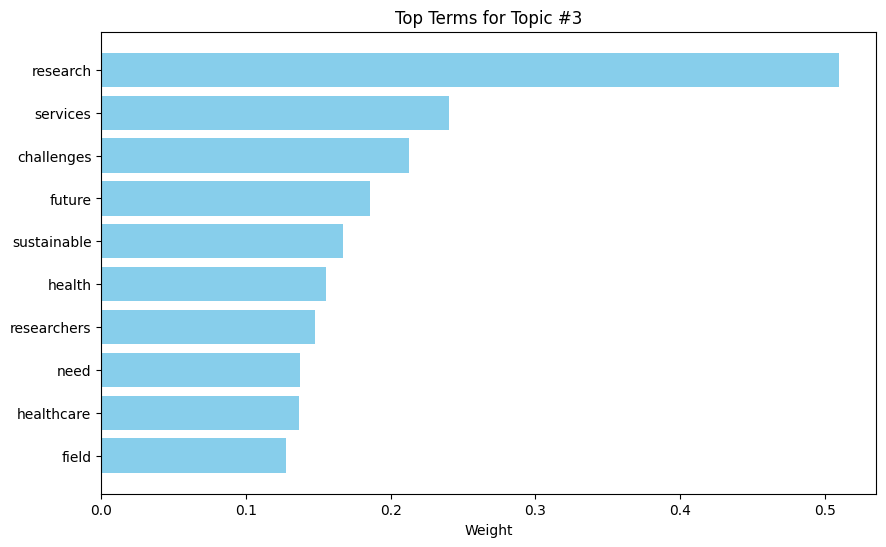

Topic #4:
virus diagnosis vbvds samples iran rna cases new arboviruses wnv


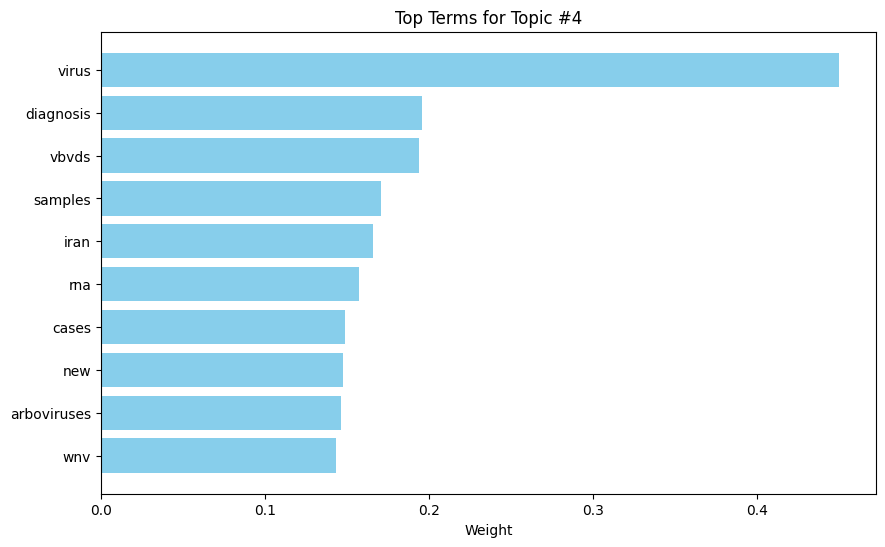

In [27]:
            # NMF Topic Modeling
            print("NMF Topic Modeling:")
            nmf_topic_modeling(df_articles)

### Topic Modeling LDA

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

def fit_lda_model(X, num_topics=5):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    H = lda.components_
    return lda, H

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
import matplotlib.pyplot as plt

def visualize_lda_topics(H, feature_names):
    for topic_idx, topic in enumerate(H):
        print(f"Topic #{topic_idx}:")
        top_terms = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        print(" ".join(top_terms))

        # Plot the top terms
        top_term_weights = topic[topic.argsort()[:-10 - 1:-1]]
        plt.figure(figsize=(10, 6))
        plt.barh(top_terms, top_term_weights, color='skyblue')
        plt.xlabel('Weight')
        plt.title(f'Top Terms for Topic #{topic_idx}')
        plt.gca().invert_yaxis()
        plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Define the LDA topic modeling function with visualization
def lda_topic_modeling(df_articles, num_topics=5):
    # Use TF-IDF to find important terms
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df_articles['processed_abstract_str'])

    # Apply LDA for topic modeling
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    H = lda.components_

    # Display and visualize topics
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(H):
        print(f"Topic #{topic_idx}:")
        top_terms = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        print(" ".join(top_terms))

        # Plot the top terms
        top_term_weights = topic[topic.argsort()[:-10 - 1:-1]]
        plt.figure(figsize=(10, 6))
        plt.barh(top_terms, top_term_weights, color='skyblue')
        plt.xlabel('Weight')
        plt.title(f'Top Terms for Topic #{topic_idx}')
        plt.gca().invert_yaxis()
        plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0:
research climate young change dogs visibility people health articles planetary


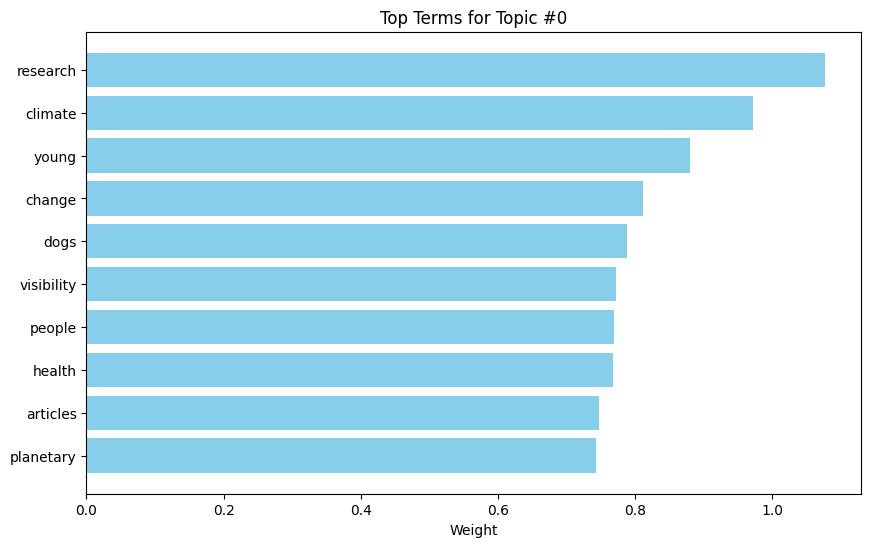

Topic #1:
compounds bmaa extract germination physical activity exposure plant soil control


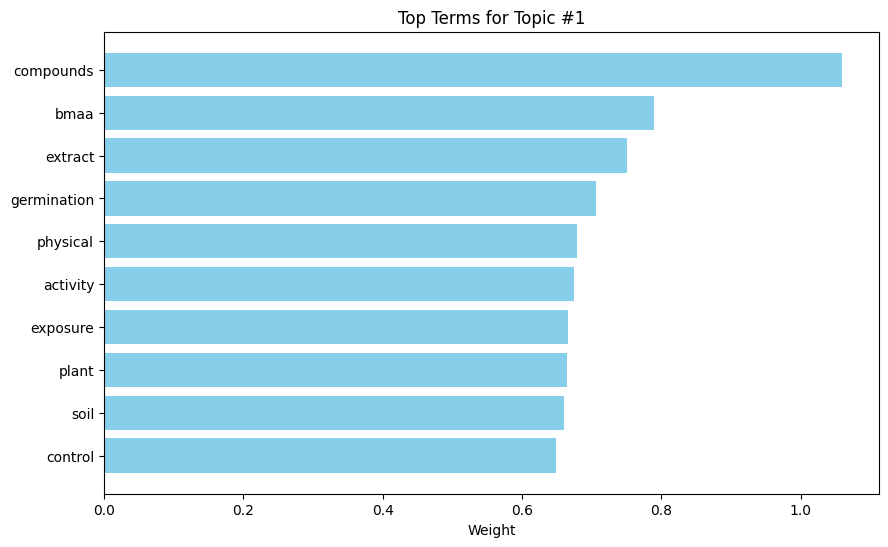

Topic #2:
cholera virus services vbvds diagnosis health iran genotype associated research


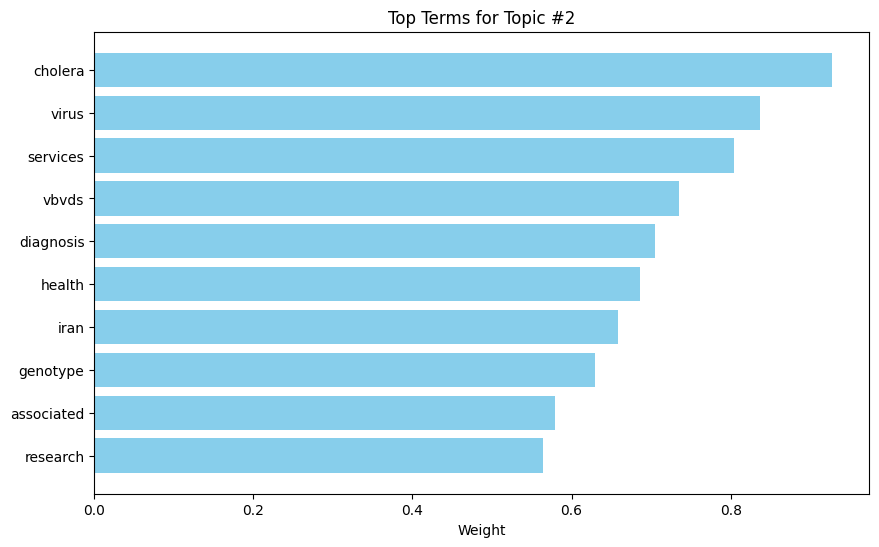

Topic #3:
temperature heat mortality extreme patients resistance illness dtr coastal mental


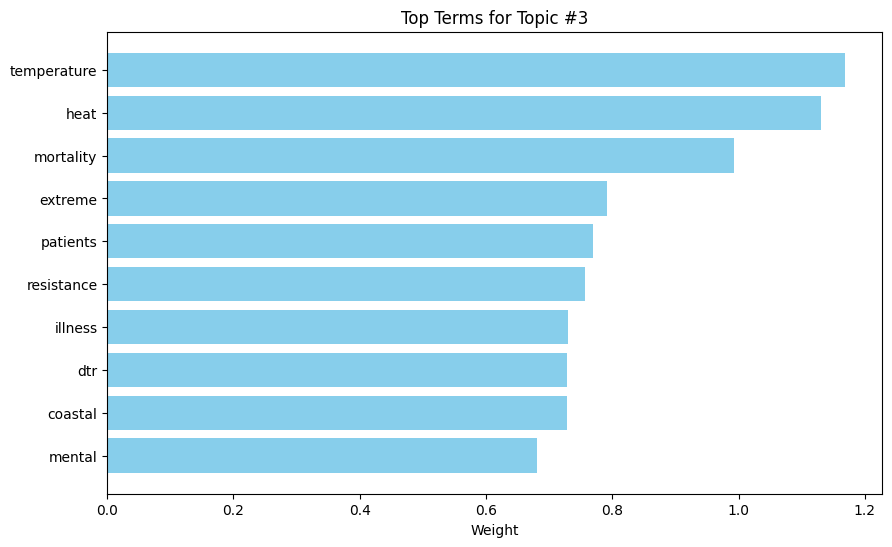

Topic #4:
research health gi climate change environmental mycotoxins arboviruses amr biofilm


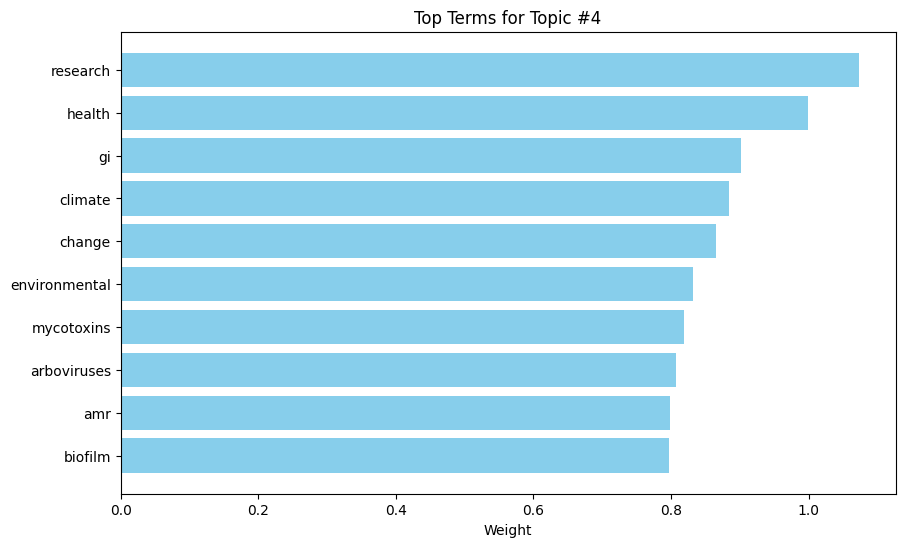

In [27]:
lda_topic_modeling(df_articles)

### Sentiment Analysis

In [10]:
def sentiment_analysis(df_articles):
    sid = SentimentIntensityAnalyzer()
    df_articles['sentiment'] = df_articles['Abstract'].apply(lambda x: sid.polarity_scores(x)['compound'])
    plt.figure(figsize=(12, 6))
    sns.histplot(df_articles['sentiment'], bins=20, kde=True)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
